In [230]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from te import transfer_entropy
from cjte import calculate_cjte
import re

In [231]:
def find_peaks(
    signal: np.array,
    sampling_rate: int = 200,
    mindelay: float = 0.3,
) -> np.array:    
    # Fill missing values
    filled_signal = nk.signal_fillmissing(signal)
    cleaned_signal = nk.ppg_clean(filled_signal, sampling_rate=sampling_rate, method="elgendi")
    peaks_up = nk.ppg_findpeaks(
        cleaned_signal, sampling_rate=sampling_rate, method="elgendi", mindelay=mindelay
    )['PPG_Peaks']
    peaks_down = nk.ppg_findpeaks(
        cleaned_signal * -1, sampling_rate=sampling_rate, method="elgendi", mindelay=mindelay
    )['PPG_Peaks']
    return peaks_up, peaks_down

In [232]:
def get_hp(peaks: np.array, sampling_rate: int = 200):
    rr = np.diff(peaks) / sampling_rate
    hp = 1 / rr
    return hp

def get_sap(signal, peaks):
    sap = np.array([signal[peak] for peak in peaks])[1:] # skip first peak to match length of hp
    return sap

def get_map(signal, peaks_up, peaks_down):
    peaks = np.sort(np.concatenate((peaks_up, peaks_down)))
    first_peak = 0 if peaks[0] < peaks[1] else 1

    # MAP = (2*DP + SP) / 3
    map_ = []
    for i in range(first_peak, len(peaks)-2, 2):
        dp = signal[peaks[i]]
        sp = signal[peaks[i+1]]
        map_.append((2*dp + sp) / 3)
    
    return np.array(map_)

def get_mcbfv(signal, peaks):
    mcbfv = np.array([np.mean(signal[peaks[i-1]:peaks[i]]) for i, _ in enumerate(peaks) if i > 0])
    return mcbfv

In [233]:
def read_fv(location):
    possible_fv_names = ['fvl', 'fvr']
    fvl = pd.read_csv(location, sep=';', decimal=',')['fvl'].values
    fvr = pd.read_csv(location, sep=';', decimal=',')['fvr'].values
    fvl_mean = np.mean(fvl)
    fvr_mean = np.mean(fvr)

    if fvl_mean > 30:
        return fvl
    elif fvr_mean > 30:
        return fvr
    else:
        return None

In [234]:
def plot_signals(signals):
    fig, axs = plt.subplots(5, 1, figsize=(20, 10))
    for i, (key, value) in enumerate(signals.items()):
        axs[i].plot(value)
        axs[i].set_title(key)
    plt.show()

In [235]:
def get_signals(file_location, sampling_rate: int = 200, mindelay: float = 0.3):
    signals = {}
    abp = pd.read_csv(file_location, sep=';', decimal=',')['abp_cnap[mmHg]'].values
    fv = read_fv(file_location)
    if fv is None:
        return None
        
    abp_peaks_up, abp_peaks_down = find_peaks(abp, sampling_rate, mindelay)
    fv_peaks_up, fv_peaks_down = find_peaks(fv, sampling_rate, mindelay)

    signals['HP'] = get_hp(abp_peaks_up)
    signals['SAP'] = get_sap(abp, abp_peaks_up)
    signals['MAP'] = get_map(abp, abp_peaks_up, abp_peaks_down)
    signals['MCBFV'] = get_mcbfv(fv, fv_peaks_down)
    signals['R'] = pd.read_csv(file_location, sep=';', decimal=',')['rr[rpm]'].values
    if re.search('BASELINE', file_location) is None:
        print(np.mean(signals['R']), np.std(signals['R']))
    return signals

In [236]:
def calculate_te(signals):
    te = {}
    te['HP->SAP'] = transfer_entropy(signals["HP"], signals["SAP"])
    te['SAP->HP'] = transfer_entropy(signals["SAP"], signals["HP"])
    # adjust lenght of MAP and MCBFV
    min_len = min(len(signals["MAP"]), len(signals["MCBFV"]))
    signals["MAP"] = signals["MAP"][:min_len]
    signals["MCBFV"] = signals["MCBFV"][:min_len]
    te['MCBFV->MAP'] = transfer_entropy(signals["MCBFV"], signals["MAP"])
    te['MAP->MCBFV'] = transfer_entropy(signals["MAP"], signals["MCBFV"])
    return te

In [237]:
def conditional_joint_transfer_entropy(signals):
    cjte = {}
    r_widnowed = np.array_split(signals["R"], len(signals["HP"]))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['HP->SAP'] = calculate_cjte(signals["HP"], signals["SAP"], signalsr_matched)
    cjte['SAP->HP'] = calculate_cjte(signals["SAP"], signals["HP"], signalsr_matched)

    min_len = min(len(signals["MAP"]), len(signals["MCBFV"]))
    signals["MAP"] = signals["MAP"][:min_len]
    signals["MCBFV"] = signals["MCBFV"][:min_len]
    r_widnowed = np.array_split(signals["R"], len(signals["MAP"]))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['MCBFV->MAP'] = calculate_cjte(signals["MCBFV"], signals["MAP"], signalsr_matched)
    cjte['MAP->MCBFV'] = calculate_cjte(signals["MAP"], signals["MCBFV"], signalsr_matched)
    return cjte

Invalid fv for data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_28/CLEAN_DATA_BASELINE/OCH_28_CLEAN_CB_BASELINE.csv
5.944720355586748 0.20327311062678352
6.194962541108527 1.3270847847628429
Invalid fv for data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_4/CLEAN_DATA_6_BREATHS/OCH_4_CLEAN_CB_6.csv
5.987 0.0
6.1040796877301515 0.73058088886373
5.988 0.0
6.039793360914588 0.22242608256713328
5.988000000000001 8.881784197001252e-16
5.988 0.0
6.684078847237881 2.347654013512741
7.416004839932358 3.009623606154108
5.999002156953655 0.29603795689862533
6.12955780806753 0.6747199186555837
5.996361909076374 0.46576791509345344
6.240686691968282 1.1265030358912775
5.988 0.0
6.087747179496013 0.5091912173586054
6.004441952993257 0.6930839679645724
6.031895322453965 0.20561077398280075
6.145712698109605 0.36598277534791246
7.375810282352098 2.532929005645464
6.046335022026432 0.23524538759727556
7.158489020997551 5.378280470841932
5.991677058353318 0.3645279994141914
7.24966623439001 2.998742690929102
5.9883

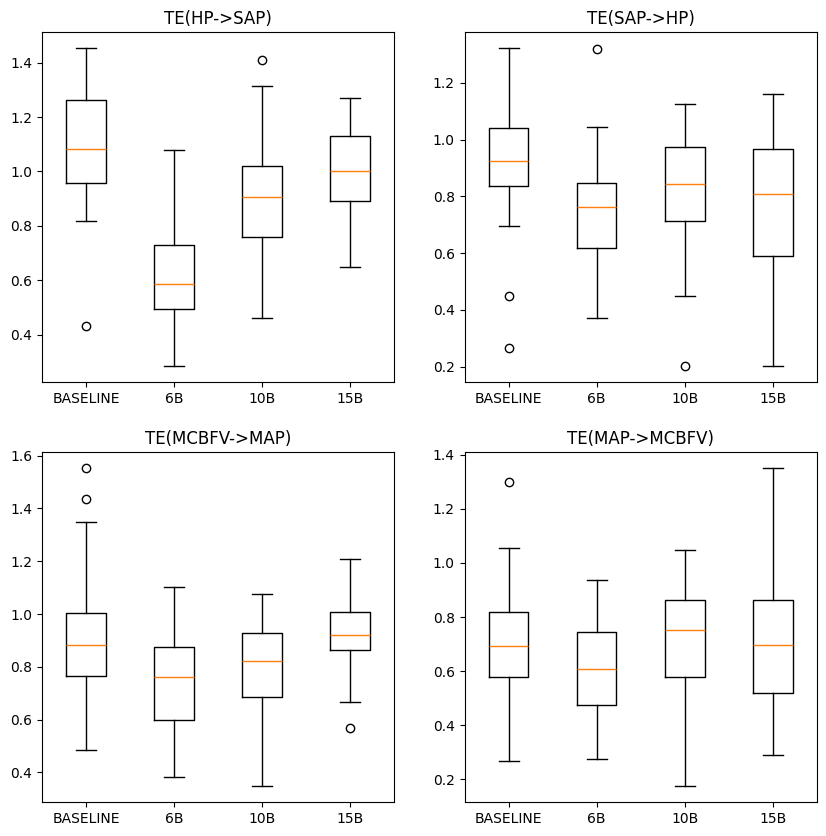

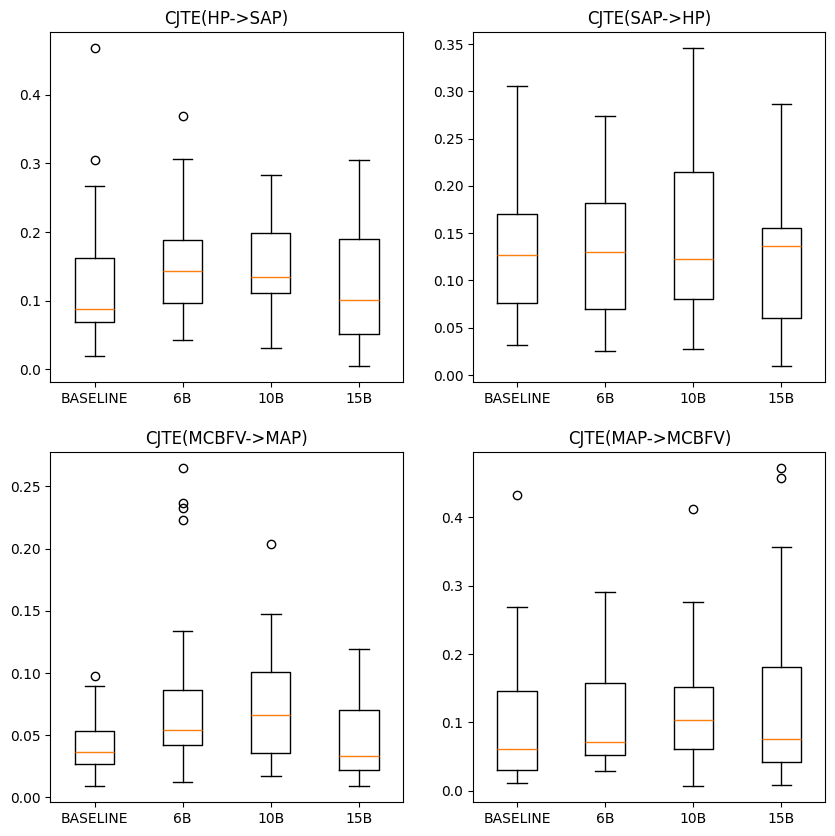

In [238]:
valid_datasets = [i for i in range(1, 38) if i not in [3, 7, 14, 15, 10, 11, 17, 27, 35]]

location_baseline = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_BASELINE/OCH_{on}_CLEAN_CB_BASELINE.csv'
location_6 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_6_BREATHS/OCH_{on}_CLEAN_CB_6.csv'
location_10 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_10_BREATHS/OCH_{on}_CLEAN_CB_10.csv'
location_15 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_15_BREATHS/OCH_{on}_CLEAN_CB_15.csv'
rc_hp_sap = []
rc_sap_hp = []
rc_mcbfv_map = []
rc_map_mcbfv = []
rc_hp_sap_cjte = []
rc_sap_hp_cjte = []
rc_mcbfv_map_cjte = []
rc_map_mcbfv_cjte = []
for loc in [location_baseline, location_6, location_10, location_15]:
    r_hp_sap = []
    r_sap_hp = []
    r_mcbfv_map = []
    r_map_mcbfv = []
    r_hp_sap_cjte = []
    r_sap_hp_cjte = []
    r_mcbfv_map_cjte = []
    r_map_mcbfv_cjte = []
    for on in valid_datasets:
        location = loc(on)
        #print(location)
        signals = get_signals(location)
        if signals is None:
            print(f'Invalid fv for {location}')
            continue

        results = calculate_te(signals)
        r_hp_sap.append(results['HP->SAP'])
        r_sap_hp.append(results['SAP->HP'])
        r_mcbfv_map.append(results['MCBFV->MAP'])
        r_map_mcbfv.append(results['MAP->MCBFV'])
        results_cjte = conditional_joint_transfer_entropy(signals)
        r_hp_sap_cjte.append(results_cjte['HP->SAP'])
        r_sap_hp_cjte.append(results_cjte['SAP->HP'])
        r_mcbfv_map_cjte.append(results_cjte['MCBFV->MAP'])
        r_map_mcbfv_cjte.append(results_cjte['MAP->MCBFV'])
    rc_hp_sap.append(r_hp_sap)
    rc_sap_hp.append(r_sap_hp)
    rc_mcbfv_map.append(r_mcbfv_map)
    rc_map_mcbfv.append(r_map_mcbfv)
    rc_hp_sap_cjte.append(r_hp_sap_cjte)
    rc_sap_hp_cjte.append(r_sap_hp_cjte)
    rc_mcbfv_map_cjte.append(r_mcbfv_map_cjte)
    rc_map_mcbfv_cjte.append(r_map_mcbfv_cjte)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].boxplot(rc_hp_sap)
axs[0, 0].set_title('TE(HP->SAP)')
axs[0, 1].boxplot(rc_sap_hp)
axs[0, 1].set_title('TE(SAP->HP)')
axs[1, 0].boxplot(rc_mcbfv_map)
axs[1, 0].set_title('TE(MCBFV->MAP)')
axs[1, 1].boxplot(rc_map_mcbfv)
axs[1, 1].set_title('TE(MAP->MCBFV)')
for i in range(2):
    for j in range(2):
        axs[i, j].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].boxplot(rc_hp_sap_cjte)
axs[0, 0].set_title('CJTE(HP->SAP)')
axs[0, 1].boxplot(rc_sap_hp_cjte)
axs[0, 1].set_title('CJTE(SAP->HP)')
axs[1, 0].boxplot(rc_mcbfv_map_cjte)
axs[1, 0].set_title('CJTE(MCBFV->MAP)')
axs[1, 1].boxplot(rc_map_mcbfv_cjte)
axs[1, 1].set_title('CJTE(MAP->MCBFV)')
for i in range(2):
    for j in range(2):
        axs[i, j].set_xticklabels(['BASELINE', '6B', '10B', '15B'])
plt.show()

